# Image Classification with Euclidean and Hyperbolic Neural Network

Welcome to our first notebook for the ECCV 2022 Tutorial "[Hyperbolic Representation Learning for Computer Vision](https://sites.google.com/view/hyperbolic-tutorial-eccv22)"!

**TODO1**: change these links

**Open notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/asci_cbl_practicals/blob/main/notebooks/1_MLPs.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/asci_cbl_practicals/blob/main/notebooks/1_MLPs.ipynb)  

**Author:** Mina Ghadimi Atigh

In this notebook, you will perform a simple image classification task using two Neural Networks, one in Euclidean space and one in the hyperbolic space. The main goal is to go through the training and testing process in Euclidean and hyperbolic spaces and see the similarities and the differences.

If you prefer working with standard python scripts, feel free to convert this notebook into a python script. To open this notebook on Google Colab, use the button above. Note that you need to copy this notebook into your own Google Drive to save the notebook and trained models. Otherwise, your progress will be lost when you close the browser tab.


Let's start with importing the libraries and setting manual seed using `set_seed`.

In [1]:
## standard libraries
import numpy as np
import warnings
from IPython.display import clear_output

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## PyTorch Torchvision
import torchvision

warnings.filterwarnings('ignore')

In [2]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


For the Hyperbolic layers and functions, we're going to use geoopt library in this notebook.

In [3]:
!pip install -q git+https://github.com/geoopt/geoopt.git
! [ ! -f mobius_linear_example.py ] && wget -q https://raw.githubusercontent.com/geoopt/geoopt/master/examples/mobius_linear_example.py

In [3]:
import geoopt
from mobius_linear_example import MobiusLinear

Here, we define the paths which will be used in this notebook.

In [4]:
DATA_PATH = './data'

Let's start with setting up the dataset. In this notebook, you will work with `MNIST` dataset. MNIST consists of 70000 tiny (28*28) gray scale images of handwritten digits, from zero to nine. The goal is to recognize the digit corresponding to each image.

In [5]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

# Train dataset - downloading the training dataset. Training dataset is splitted into train and val parts.
main_trainset = torchvision.datasets.MNIST(root=DATA_PATH, train = True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(main_trainset, [10000, 50000], generator=torch.Generator().manual_seed(42))

# Test dataset - downloading and loading the testing dataset.
testset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
testset_small, _ = torch.utils.data.random_split(main_trainset, [30000, 30000], generator=torch.Generator().manual_seed(42))

# Create dataloaders for the train, val and test sets
batch_size = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_small, batch_size=batch_size, shuffle=False, num_workers=2)

Before starting the main task, let's visualize some of the images from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


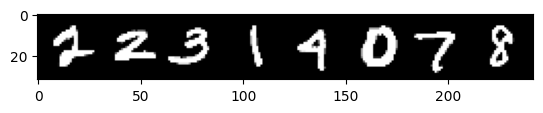

     2    2    3    1    4    0    7    8   


In [6]:
# Extract class names
classes = torchvision.datasets.MNIST.classes
# Class names are like 0 - zero
classes_num = [c.split('-')[0] for c in classes]

# functions to show an image
def imshow(img):
    # What should I do here to unnormalize? 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print('     '+' '.join(f'{classes_num[labels[j]]:4s}' for j in range(batch_size)))

## Implementing Neural Networks

### Euclidean Neural Network

Let's start with defining a simple Euclidean neural network. Our simple neural network consists of three fully connected layers. To create the fully connected layers in Euclidean space, `nn.Linear` in used.

In [15]:
class EuclideanNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 750)
        self.relu1 = nn.ReLU()
        self.fc11 = nn.Linear(750, 20)
        self.relu11 = nn.ReLU()
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        out_x = self.fc1(x)
        out_x = self.relu1(out_x)
        out_x = self.fc11(out_x)
        out_x = self.relu11(out_x)
        out_x = self.fc2(out_x)
        return out_x

euclidean_net = EuclideanNet().to(device)

### Hyperbolic Neural Network

Next step is to create a neural network in hyperbolic space. This network consists of three fully connected layer, similar to the netowrk defined in the Euclidean space. To define a fully connected layer in the hyperbolic space, `MobiusLinear` is used.

In [16]:
def hyperbolic_ReLU(hyperbolic_input, manifold):
    euclidean_input = manifold.logmap0(hyperbolic_input)
    euclidean_output = F.relu(euclidean_input)
    hyperbolic_output = manifold.expmap0(euclidean_output)
    return hyperbolic_output

In [17]:
class HyperbolicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = MobiusLinear(28 * 28, 750)
        self.fc11 = MobiusLinear(750, 20)
        self.fc2 = MobiusLinear(20, 10)

    def forward(self, x, manifold):
        out_x = self.fc1(x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc11(out_x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc2(out_x)
        return out_x

hyperbolic_net = HyperbolicNet().to(device)

Here you can see the overview of both Euclidean and hyperbolic Neural Networks. The main structure of the networks are similar, one consisting of *Euclidean* Linear layers and the other one of *hyperbolic* layers. 

As the Hyperbolic Net consists of hyperbolic layers, the input must be in hyperbolic space, too. Therefore, `Exp map` which stands for `Exponential Map` is used to project the input of the Neural Network (flatten image) from Euclidean space to the hyperbolic space. `Exp map` will be performed later in the training and testing loop.

<center width="90%"><img src="figures/1_net.png"></center>

### Optimizer and Loss function

Next step is to define the optimizer and loss function. For training a neural network with hyperbolic layers, the optimizer should be in hyperbolic space, too. Here we use `SGD` and `Riemannian SGD` as the optimizers.

In [18]:
criterion = nn.CrossEntropyLoss()
euclidean_optimizer = optim.SGD(euclidean_net.parameters(), lr=0.001, momentum=0.9)
hyperbolic_optimizer = geoopt.optim.RiemannianSGD(list(hyperbolic_net.parameters()), lr=0.001, momentum=0.9)

Finally, it's time to implement the training loop.

### Euclidean training loop

First, we start with training the Euclidean neural network.

In [19]:
for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        euclidean_optimizer.zero_grad()

        # forward + backward + optimize
        flatten_inputs = torch.flatten(inputs, start_dim=1)
        outputs = euclidean_net(flatten_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        euclidean_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (epoch % 100) == 0:
            if (i % len(trainloader)) == (len(trainloader) - 1):   
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')
                running_loss = 0.0
                # ================================================================================
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in valloader:
                        val_images, val_labels = data
                        val_images = val_images.to(device)
                        val_labels = val_labels.to(device)
                        # calculate outputs by running images through the network
                        flatten_val_images = torch.flatten(val_images, start_dim=1)
                        val_outputs = euclidean_net(flatten_val_images)
                        # the class with the highest energy is what we choose as prediction
                        _, val_predicted = torch.max(val_outputs.data, 1)
                        total += val_labels.size(0)
                        correct += (val_predicted == val_labels).sum().item()
                print(f'Accuracy of the network on the 10000 val images: {100 * correct // total} %')
                # ================================================================================
print('Finished Training')

[1,  1250] loss: 0.732
Accuracy of the network on the 10000 val images: 89 %
[101,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[201,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[301,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[401,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[501,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[601,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[701,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[801,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
[901,  1250] loss: 0.000
Accuracy of the network on the 10000 val images: 96 %
Finished Training


### Hyperbolic training loop

Next step is to train the hyperbolic neural network. 

In addition to the optimizers, there is one more difference between Euclidean and hyperbolic training loops; `Exponential Map`. As the hyperbolic Net expects hyperbolic input, data is projected to the hyperbolic space using `manifold.expmap0(flat_inputs)`.


In [20]:
manifold = geoopt.PoincareBall()

for epoch in range(1000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        hyperbolic_optimizer.zero_grad()

        # forward + backward + optimize
        # ------------------------------
        # Hyperbolic inputs
        flat_inputs = torch.flatten(inputs, start_dim=1)
        hyp_inputs = manifold.expmap0(flat_inputs)
        # ------------------------------
        outputs = hyperbolic_net(hyp_inputs, manifold)
        loss = criterion(outputs, labels)
        loss.backward()
        hyperbolic_optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (epoch % 100) == 0:
            # print statistics
            if (i % len(trainloader)) == (len(trainloader) - 1):   
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.3f}')
                running_loss = 0.0
                # ================================================================================
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in valloader:
                        val_images, val_labels = data

                        val_images = val_images.to(device)
                        val_labels = val_labels.to(device)

                        # calculate outputs by running images through the network
                        flatten_val_images = torch.flatten(val_images, start_dim=1)
                        hyp_flatten_val_images = manifold.expmap0(flatten_val_images)
                        val_outputs = hyperbolic_net(hyp_flatten_val_images, manifold)
                        # the class with the highest energy is what we choose as prediction
                        _, val_predicted = torch.max(val_outputs.data, 1)
                        total += val_labels.size(0)
                        correct += (val_predicted == val_labels).sum().item()
                print(f'Accuracy of the network on the 10000 val images: {100 * correct // total} %')
                # ================================================================================
print('Finished Training')

[1,  1250] loss: 1.975
Accuracy of the network on the 10000 val images: 82 %
[101,  1250] loss: 1.430
Accuracy of the network on the 10000 val images: 95 %
[201,  1250] loss: 1.427
Accuracy of the network on the 10000 val images: 95 %
[301,  1250] loss: 1.426
Accuracy of the network on the 10000 val images: 95 %
[401,  1250] loss: 1.425
Accuracy of the network on the 10000 val images: 95 %
[501,  1250] loss: 1.425
Accuracy of the network on the 10000 val images: 95 %
[601,  1250] loss: 1.424
Accuracy of the network on the 10000 val images: 95 %
[701,  1250] loss: 1.424
Accuracy of the network on the 10000 val images: 95 %
[801,  1250] loss: 1.424
Accuracy of the network on the 10000 val images: 95 %
[901,  1250] loss: 1.424
Accuracy of the network on the 10000 val images: 95 %
Finished Training


### Testing function
Once the training loop is complete, it's time to see how the trained Euclidean and hyperbolic models work given the testing split.

First, we visualize a batch of test images and the predicted labels given the batch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


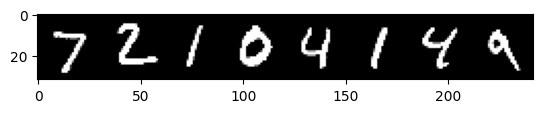

GroundTruth: 7   2   1   0   4   1   4   9  
Euclidean:   7   2   1   0   4   1   4   9  
Hyperbolic:  7   2   1   0   4   1   4   9  


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

flatten_images = torch.flatten(images, start_dim=1).to(device)
# ======================================
outputs = euclidean_net(flatten_images)
_, euclidean_predicted = torch.max(outputs, 1)
# ======================================
hyp_inputs = manifold.expmap0(flatten_images)
outputs = hyperbolic_net(hyp_inputs, manifold)
_, hyperbolic_predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(f'{classes_num[labels[j]]:3s}' for j in range(8)))
print('Euclidean:  ', ' '.join(f'{classes_num[euclidean_predicted[j]]:3s}' for j in range(8)))
print('Hyperbolic: ', ' '.join(f'{classes_num[hyperbolic_predicted[j]]:3s}' for j in range(8)))

In [30]:
# Test dataset - downloading and loading the testing dataset.
testset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
testset_small, _ = torch.utils.data.random_split(main_trainset, [30000, 30000], generator=torch.Generator().manual_seed(42))

# Create dataloaders for the train, val and test sets
batch_size = 8
testloader = torch.utils.data.DataLoader(testset_small, batch_size=batch_size, shuffle=False, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

euclidean_correct = 0
hyperbolic_correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        flatten_images = torch.flatten(images, start_dim=1)

        euclidean_outputs = euclidean_net(flatten_images)
        # ======================================
        hyp_inputs = manifold.expmap0(flatten_images)
        hyperbolic_outputs = hyperbolic_net(hyp_inputs, manifold)

        # the class with the highest energy is what we choose as prediction
        _, euclidean_predicted = torch.max(euclidean_outputs.data, 1)
        _, hyperbolic_predicted = torch.max(hyperbolic_outputs.data, 1)
        total += labels.size(0)

        euclidean_correct += (euclidean_predicted == labels).sum().item()
        hyperbolic_correct += (hyperbolic_predicted == labels).sum().item()

print(f'Accuracy of the Euclidean network on the 10000 test images: {100 * euclidean_correct // total} %')
print(f'Accuracy of the Hyperbolic network on the 10000 test images: {100 * hyperbolic_correct // total} %')

Accuracy of the Euclidean network on the 10000 test images: 97 %
Accuracy of the Hyperbolic network on the 10000 test images: 97 %
